In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from matplotlib.pyplot import figure
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import sys
from copy import copy
import time
from datetime import datetime, timedelta
from collections import OrderedDict
import analysis_utils as utils
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from datetime import date

In [139]:
#pip install arrow

In [140]:
import arrow

In [141]:
# for now, data is in C:\bonsai\data\Quentin and analysis script is in C:\Users\qpmoric\Desktop\gd_analysis
# data should also be on the server in W:\akrami\mouse_data\Quentin

In [142]:
animals = ['QP01','QP02','QP03']

datadir = (r'C:\bonsai\data\Quentin')
#datadir = (r'W:\akrami\mouse_data\Quentin')
dates = ['13/10/2021', date.today().strftime("%d/%m/%Y")] # get data up to current date
plot_colours = ['b','r','c','m','y','g']

trial_data = utils.merge_sessions(datadir,animals,'TrialData',dates)
trial_data = pd.concat(trial_data, sort=False, axis=0)

In [143]:
trial_data.reset_index(level=1, inplace=True)
trial_data.reset_index(level=0, inplace=True)

In [144]:
# remove sessions with less than 30 trials
n = 30
df = []

for Date in trial_data.Date.unique():
    if len(trial_data[trial_data.Date == Date]) >= n:
        df.append(trial_data[trial_data.Date == Date])
trial_data = pd.concat(df, ignore_index=True)

In [145]:
# add correct, incorrect & violation columns

# trial_data['Correct'] = np.where(trial_data.Trial_Outcome == 1, 1, 0)
# trial_data['Incorrect'] = np.where(trial_data.Trial_Outcome == 0, 1, 0)
# trial_data['Violation'] = np.where(trial_data.Trial_Outcome == -1, 1, 0)

In [146]:
# add correct, no_response & violation columns

trial_data['Correct'] = np.where(trial_data.Trial_Outcome == 1, 1, 0)
trial_data['No_Response'] = np.where(trial_data.Trial_Outcome == 0, 1, 0)
trial_data['Violation'] = np.where(trial_data.Trial_Outcome == -1, 1, 0)

In [147]:
# create choice column, difference between RewardedSide and Trial_Outcome (lambda.row etc.)

# 1 = left & 2 = right; 1-1 = 0 --> left; 1-0 = 1 --> right
# 2-1 = 1 --> right; 2-0 = 2 --> left
# replace 2 w/ 0 --> 0 = left & 1 = right
# fill with NaN whenever there is a violation
 
# trial_data['Choice'] = trial_data.apply(lambda row: row.RewardedSide - row.Trial_Outcome, axis=1)
# trial_data = trial_data.replace(to_replace={'Choice': {2: 0}}, value=None)
# trial_data.loc[trial_data['Trial_Outcome'] == -1, 'Choice'] = np.nan


In [148]:
# find number of trials per session
df = pd.DataFrame(trial_data.groupby(['Date','Name']).size().reset_index(level=0, inplace=False))
trial_number = df.reset_index(level=0, inplace=False)
trial_number.rename( columns={0 :'Trial_number'}, inplace=True)

In [149]:
# def RBias(Choice, Correct):
#     '''
#     %Returns the bias to the right
#     % FirstPokes is a vector of 1s and 2s (Left or Right), indicating the poked port
#     % FirstPokesCorrect is a 0 and 1 vector (wrong or correct poke)
#     % Both could have NaN values
#     % Returns from -1 to 1. 0 Being not biased, 1 being Right-biased, and
#     % -1 being left-biased. It is a conservative function. E.g, in a 50-50
#     % trial chance, and being totally biased to one side, only half of the
#     % trials would be wrong, so the function would output +/-0.5.
#     % Correct trials based on proportion of wrong pokes
#     % Determine the proportion of wrong pokes to the right side
#     '''
#     WrongSides = Choice[Correct == 0]
#     if len(WrongSides) < 1:
#         RBias = 0
#     else:
#         WrongSideProportion = len(WrongSides) / len(Choice)  # from 0 to 1
#         WrongRightsProportion = WrongSideProportion * np.nansum(WrongSides == 1) / len(WrongSides)
#         WrongLeftsProportion = WrongSideProportion * np.nansum(WrongSides == 0) / len(WrongSides)

#         RBias = WrongRightsProportion - WrongLeftsProportion
#     return RBias

In [150]:
# def CalculateRBiasWindow(Choice, Correct, Window):
#     '''Calculates RBias over the lenght of the vectors Choice and
#     Correct using a Window. Returns vector of same lenght'''
#     # Create empty vector
#     RBiasVector = np.empty(len(Choice))
#     RBiasVector[:] = np.nan
#     for i in range(Window, len(Choice)):
#         win = range((i - Window), i)
#         RBiasVector[i] = RBias(Choice[win], Correct[win])

#     return RBiasVector

In [151]:
# trial_data['RightBias'] = CalculateRBiasWindow(np.array(trial_data['Choice']),np.array(trial_data['Correct']), 50)

In [152]:
trial_data.head()

,Name,Date,Time,Trial_Outcome,Stim1_Duration,Stim1_Amplitude,Stim2_Amplitude,GoTone_Amplitude,Choice,RewardAttempts,Tone_Duration,Trial_Start,Trial_End,GoToneTime,InterTrial_Duration,RewardTone_Time,InterStim_Interval,Reward_Amount,Withdraw_WaitTime,WarmUp,RewardLED_Duration,Response_Window,RewardSide,Correct,No_Response,Violation,RightBias
0,QP01,211013,14:05:15.5528704,1,0.100,80,80,80,0,3,0.25,14:05:14.4576000,14:05:14.6793088,14:05:14.4588160,0.5,14:05:14.6642816,00:00:00.2500000,2.0,0.1,True,0,10,1,1,0,0,NaN
1,QP01,211013,14:05:19.0519040,1,0.106,80,80,80,0,3,0.25,14:05:18.2030080,14:05:18.2087296,14:05:18.2037632,0.5,14:05:18.2079744,00:00:00.2500000,2.0,0.1,True,0,10,1,1,0,0,NaN
2,QP01,211013,14:05:22.0414848,1,0.112,80,80,80,0,3,0.25,14:05:21.1573120,14:05:21.2054016,14:05:21.1588224,0.5,14:05:21.1898496,00:00:00.2500000,2.0,0.1,True,0,10,1,1,0,0,NaN
3,QP01,211013,14:05:25.7241472,1,0.118,80,80,80,0,3,0.25,14:05:24.7837696,14:05:24.8835712,14:05:24.7993472,0.5,14:05:24.8828160,00:00:00.2500000,2.0,0.1,True,0,10,1,1,0,0,NaN
4,QP01,211013,14:05:28.7793024,1,0.125,80,80,80,0,3,0.25,14:05:27.9283072,14:05:27.9358976,14:05:27.9302784,0.5,14:05:27.9352320,00:00:00.2500000,2.0,0.1,True,0,10,1,1,0,0,NaN


In [153]:
# figure(figsize=(14, 22))
# rows,colums = 5,2
# legend_rotation = 90
# alpha = 0.3
# plt.subplot(rows,colums,1)
# g = sns.pointplot(data = trial_data, x = 'Date', y = 'Correct', hue = 'Name')
# plt.setp(g.collections, alpha=alpha) #for the markers
# plt.setp(g.lines, alpha=alpha)       #for the lines
# #sns.pointplot(data = trial_data, x = 'Date', y = 'Correct', color = 'k')
# #plt.xticks(np.arange(len(trial_data.Date.unique())), np.arange(1, len(trial_data.Date.unique())+1))
# #plt.xticks(rotation=legend_rotation)
# plt.axhline(y=0.5, color='grey', linestyle='--')
# plt.axvline(x=2, color='grey', linestyle='-')
# plt.title("% Correct")

# plt.subplot(rows,colums,2)
# g = sns.pointplot(data = trial_data, x = 'Date', y = 'Violation', hue = 'Name')
# plt.setp(g.collections, alpha=alpha) #for the markers
# plt.setp(g.lines, alpha=alpha)       #for the lines
# #sns.pointplot(data = trial_data, x = 'Date', y = 'Violation', color = 'k')
# #plt.xticks(np.arange(len(trial_data.Date.unique())), np.arange(1, len(trial_data.Date.unique())+1))
# plt.xticks(rotation=legend_rotation)
# plt.xlabel(' ')
# plt.axvline(x=2, color='grey', linestyle='-')
# plt.title("% Violation")

# plt.subplot(rows,colums,3)
# g = sns.pointplot(data = trial_data, x = 'Date', y = 'Stim1_Duration', hue = 'Name')
# plt.setp(g.collections, alpha=alpha) #for the markers
# plt.setp(g.lines, alpha=alpha)       #for the lines
# #sns.pointplot(data = trial_data, x = 'Date', y = 'Stim1_Duration', color = 'k')
# #plt.xticks(np.arange(len(trial_data.Date.unique())), np.arange(1, len(trial_data.Date.unique())+1))
# plt.xticks(rotation=legend_rotation)
# plt.xlabel('Session_date')
# plt.title("Stim1 Duration")
# plt.axvline(x=2, color='grey', linestyle='-')
# plt.tight_layout()

# plt.subplot(rows,colums,4)
# g = sns.pointplot(data = trial_data, x = 'Date', y = 'RewardAttempts', hue = 'Name')
# plt.setp(g.collections, alpha=alpha) #for the markers
# plt.setp(g.lines, alpha=alpha)       #for the lines
# #sns.pointplot(data = trial_data, x = 'Date', y = 'RewardAttempts', color = 'k')
# #plt.xticks(np.arange(len(trial_data.Date.unique())), np.arange(1, len(trial_data.Date.unique())+1))
# plt.xticks(rotation=legend_rotation)
# plt.xlabel('Session_date')
# plt.title("Reward_Attempts")
# plt.axvline(x=2, color='grey', linestyle='-')
# plt.tight_layout()

# plt.subplot(rows,colums,5)
# g = sns.pointplot(data = trial_data, x = 'Date', y = 'Response_Window', hue = 'Name')
# plt.setp(g.collections, alpha=alpha) #for the markers
# plt.setp(g.lines, alpha=alpha)       #for the lines
# #sns.pointplot(data = trial_data, x = 'Date', y = 'Response_Window', color = 'k')
# #plt.xticks(np.arange(len(trial_data.Date.unique())), np.arange(1, len(trial_data.Date.unique())+1))
# plt.xticks(rotation=legend_rotation)
# plt.xlabel('Session_date')
# plt.title("Response_Window")
# plt.axvline(x=2, color='grey', linestyle='-')
# plt.tight_layout()

# # plt.subplot(rows,colums,6)
# # g = sns.pointplot(data = trial_data, x = 'Date', y = 'RightBias', hue = 'Name')
# # plt.setp(g.collections, alpha=alpha) #for the markers
# # plt.setp(g.lines, alpha=alpha)       #for the lines
# # #sns.pointplot(data = trial_data, x = 'Date', y = 'RightBias', color = 'k')
# # #plt.xticks(np.arange(len(trial_data.Date.unique())), np.arange(1, len(trial_data.Date.unique())+1))
# # plt.xticks(rotation=legend_rotation)
# # plt.axhline(y=0, color='grey', linestyle='--')
# # plt.xlabel('Session_date')
# # plt.title("RightBias")
# # plt.axvline(x=2, color='grey', linestyle='-')
# # plt.tight_layout()

# plt.subplot(rows,colums,7)
# g = sns.pointplot(data = trial_number, x = 'Date', y = 'Trial_number', hue = 'Name')
# plt.setp(g.collections, alpha=alpha) #for the markers
# plt.setp(g.lines, alpha=alpha)       #for the lines
# #sns.pointplot(data = trial_number, x = 'Date', y = 'Trial_number', color = 'k')
# #plt.xticks(np.arange(len(trial_data.Date.unique())), np.arange(1, len(trial_data.Date.unique())+1))
# plt.xticks(rotation=legend_rotation)
# plt.xlabel('Session_date')
# plt.title("Number of trials")
# plt.axvline(x=2, color='grey', linestyle='-')
# plt.tight_layout()

# plt.subplot(rows,colums,8)
# x = trial_data.groupby(['Stim1_Duration']).mean().reset_index(level=0, inplace=False).Stim1_Duration
# y = trial_data.groupby(['Stim1_Duration']).mean().reset_index(level=0, inplace=False).Correct
# plt.plot(x, y, 'bo',markersize = 1)
# m, b = np.polyfit(x, y, 1)
# plt.plot(x, m*x + b, color = 'red')
# plt.xlabel('Delay_duration')
# plt.ylabel("%Correct")
# plt.title('Performance \n Vs \n Delay Duration')
# plt.tight_layout()

# plt.subplot(rows,colums,9)
# x = trial_data.groupby(['Stim1_Duration']).mean().reset_index(level=0, inplace=False).Stim1_Duration
# y = trial_data.groupby(['Stim1_Duration']).mean().reset_index(level=0, inplace=False).Violation
# plt.plot(x, y, 'bo',markersize = 1)
# m, b = np.polyfit(x, y, 1)
# plt.plot(x, m*x + b, color = 'red')
# plt.xlabel('Delay_duration')
# plt.ylabel("%Violation")
# plt.title('Violation \n Vs \n Delay Duration')
# plt.tight_layout()

# plt.show()

In [154]:
# def stage(row): 
#     if np.isin(row['Date'], ['210901','210902','210906', '210907', '210908']) and row['Name'] == 'QP01':
#         return 2
#     elif np.isin(row['Date'], ['210909',
#        '210910', '210913', '210914', '210915', '210916', '210917',
#        '210920', '210921', '210922', '210923', '210924', '210927',
#        '210928', '210929', '210930', '211001', '211004', '211005',
#        '211006', '211007', '211008', '211011']) and row['Name'] == 'QP01':
#         return 3
#     elif np.isin(row['Date'], ['210901','210902']) and row['Name'] == 'QP02':
#         return 2
#     elif np.isin(row['Date'], ['210906', '210907', '210908', '210909',
#        '210910', '210913', '210914', '210915', '210916', '210917',
#        '210920', '210921', '210922', '210923', '210924', '210927',
#        '210928', '210929', '210930', '211001', '211004', '211005',
#        '211006', '211007', '211008', '211011']) and row['Name'] == 'QP02':
#         return 3
#     elif np.isin(row['Date'], ['210901','210902']) and row['Name'] == 'QP03':
#         return 2
#     elif np.isin(row['Date'], ['210906', '210907', '210908', '210909',
#        '210910', '210913', '210914', '210915', '210916', '210917',
#        '210920', '210921', '210922', '210923', '210924', '210927',
#        '210928', '210929', '210930', '211001', '211004', '211005',
#        '211006', '211007', '211008', '211011']) and row['Name'] == 'QP03':
#         return 3
#         return 'Other'   

In [155]:
# trial_data.apply(lambda row: stage(row), axis=1)
# trial_data['Stage'] = trial_data.apply(lambda row: stage(row), axis=1)

In [156]:
# track performance on last session

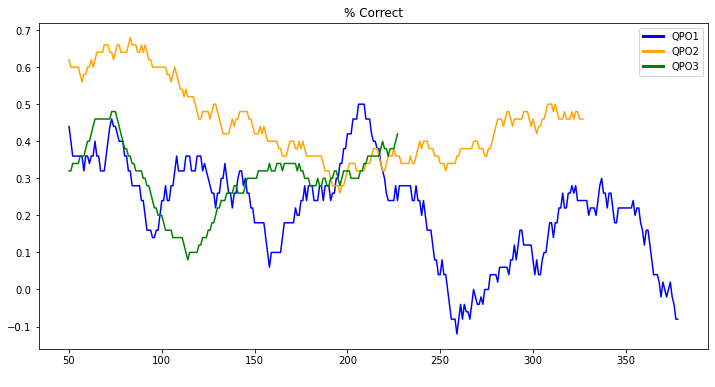

In [157]:
figure(figsize=(12, 6))

n = 50 # rolling window
date = arrow.now().format('YYMMDD')
name = 'QP01'
plt.plot(np.arange(1,len(trial_data[(trial_data.Date == date) & (trial_data.Name == name)])+1,1),
    trial_data[(trial_data.Date == date) & (trial_data.Name == name)].Trial_Outcome.rolling(n).mean(),
        color = 'b')

name = 'QP02'
plt.plot(np.arange(1,len(trial_data[(trial_data.Date == date) & (trial_data.Name == name)])+1,1),
    trial_data[(trial_data.Date == date) & (trial_data.Name == name)].Correct.rolling(n).mean(),
        color = 'orange')

name = 'QP03'
plt.plot(np.arange(1,len(trial_data[(trial_data.Date == date) & (trial_data.Name == name)])+1,1),
    trial_data[(trial_data.Date == date) & (trial_data.Name == name)].Correct.rolling(n).mean(),
        color = 'g')
plt.xlabel(' ')
#plt.axhline(y=0.5, color='grey', linestyle='--')
colors = ['b', 'orange', 'g']
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = ['QPO1', 'QPO2', 'QPO3']
plt.legend(lines, labels)
plt.title("% Correct")

plt.show()

In [158]:
# track salient trial parameters

In [159]:
trial_data.head()

,Name,Date,Time,Trial_Outcome,Stim1_Duration,Stim1_Amplitude,Stim2_Amplitude,GoTone_Amplitude,Choice,RewardAttempts,Tone_Duration,Trial_Start,Trial_End,GoToneTime,InterTrial_Duration,RewardTone_Time,InterStim_Interval,Reward_Amount,Withdraw_WaitTime,WarmUp,RewardLED_Duration,Response_Window,RewardSide,Correct,No_Response,Violation,RightBias
0,QP01,211013,14:05:15.5528704,1,0.100,80,80,80,0,3,0.25,14:05:14.4576000,14:05:14.6793088,14:05:14.4588160,0.5,14:05:14.6642816,00:00:00.2500000,2.0,0.1,True,0,10,1,1,0,0,NaN
1,QP01,211013,14:05:19.0519040,1,0.106,80,80,80,0,3,0.25,14:05:18.2030080,14:05:18.2087296,14:05:18.2037632,0.5,14:05:18.2079744,00:00:00.2500000,2.0,0.1,True,0,10,1,1,0,0,NaN
2,QP01,211013,14:05:22.0414848,1,0.112,80,80,80,0,3,0.25,14:05:21.1573120,14:05:21.2054016,14:05:21.1588224,0.5,14:05:21.1898496,00:00:00.2500000,2.0,0.1,True,0,10,1,1,0,0,NaN
3,QP01,211013,14:05:25.7241472,1,0.118,80,80,80,0,3,0.25,14:05:24.7837696,14:05:24.8835712,14:05:24.7993472,0.5,14:05:24.8828160,00:00:00.2500000,2.0,0.1,True,0,10,1,1,0,0,NaN
4,QP01,211013,14:05:28.7793024,1,0.125,80,80,80,0,3,0.25,14:05:27.9283072,14:05:27.9358976,14:05:27.9302784,0.5,14:05:27.9352320,00:00:00.2500000,2.0,0.1,True,0,10,1,1,0,0,NaN


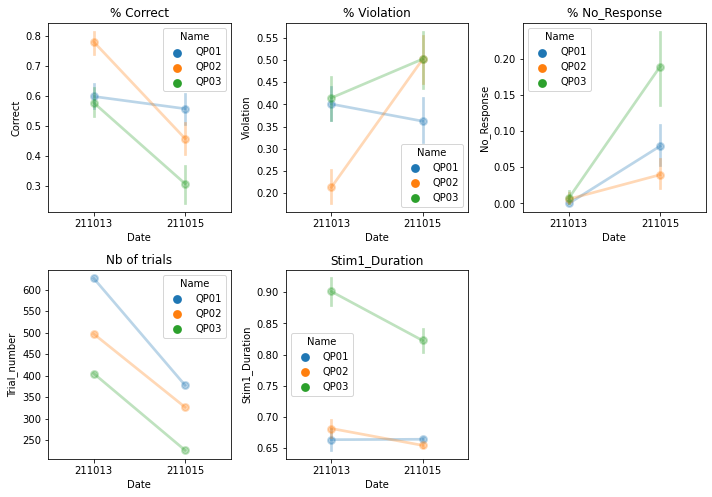

In [160]:
figure(figsize=(10, 10))
rows,colums = 3,3
legend_rotation = 90
alpha = 0.3
plt.subplot(rows,colums,1)
g = sns.pointplot(data = trial_data, x = 'Date', y = 'Correct', hue = 'Name')
plt.setp(g.collections, alpha=alpha) #for the markers
plt.setp(g.lines, alpha=alpha)       #for the lines
plt.title("% Correct")

plt.subplot(rows,colums,2)
g = sns.pointplot(data = trial_data, x = 'Date', y = 'Violation', hue = 'Name')
plt.setp(g.collections, alpha=alpha) #for the markers
plt.setp(g.lines, alpha=alpha)       #for the lines
plt.title("% Violation")

plt.subplot(rows,colums,3)
g = sns.pointplot(data = trial_data, x = 'Date', y = 'No_Response', hue = 'Name')
plt.setp(g.collections, alpha=alpha) #for the markers
plt.setp(g.lines, alpha=alpha)       #for the lines
plt.title("% No_Response")

plt.subplot(rows,colums,4)
g = sns.pointplot(data = trial_number, x = 'Date', y = 'Trial_number', hue = 'Name')
plt.setp(g.collections, alpha=alpha) #for the markers
plt.setp(g.lines, alpha=alpha)       #for the lines
plt.title("Nb of trials")

plt.subplot(rows,colums,5)
g = sns.pointplot(data = trial_data, x = 'Date', y = 'Stim1_Duration', hue = 'Name')
plt.setp(g.collections, alpha=alpha) #for the markers
plt.setp(g.lines, alpha=alpha)       #for the lines
plt.title("Stim1_Duration")

plt.tight_layout()
plt.show()

In [161]:
# seperate trial outcome by side for every mouse

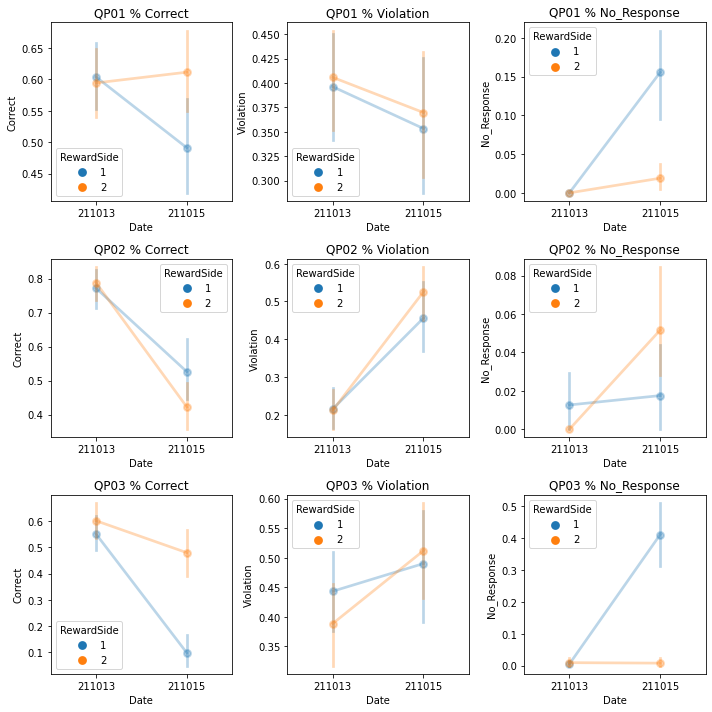

In [162]:
figure(figsize=(10, 10))
rows,colums = 3,3
legend_rotation = 90
alpha = 0.3

plt.subplot(rows,colums,1)
Name = 'QP01'
g = sns.pointplot(data = trial_data[trial_data.Name == Name], x = 'Date', y = 'Correct', hue = 'RewardSide')
plt.setp(g.collections, alpha=alpha) #for the markers
plt.setp(g.lines, alpha=alpha)       #for the lines
plt.title(Name + " % Correct")

plt.subplot(rows,colums,2)
g = sns.pointplot(data = trial_data[trial_data.Name == Name], x = 'Date', y = 'Violation', hue = 'RewardSide')
plt.setp(g.collections, alpha=alpha) #for the markers
plt.setp(g.lines, alpha=alpha)       #for the lines
plt.title(Name + " % Violation")

plt.subplot(rows,colums,3)
g = sns.pointplot(data = trial_data[trial_data.Name == Name], x = 'Date', y = 'No_Response', hue = 'RewardSide')
plt.setp(g.collections, alpha=alpha) #for the markers
plt.setp(g.lines, alpha=alpha)       #for the lines
plt.title(Name + " % No_Response")

plt.subplot(rows,colums,4)
Name = 'QP02'
g = sns.pointplot(data = trial_data[trial_data.Name == Name], x = 'Date', y = 'Correct', hue = 'RewardSide')
plt.setp(g.collections, alpha=alpha) #for the markers
plt.setp(g.lines, alpha=alpha)       #for the lines
plt.title(Name + " % Correct")

plt.subplot(rows,colums,5)
g = sns.pointplot(data = trial_data[trial_data.Name == Name], x = 'Date', y = 'Violation', hue = 'RewardSide')
plt.setp(g.collections, alpha=alpha) #for the markers
plt.setp(g.lines, alpha=alpha)       #for the lines
plt.title(Name + " % Violation")

plt.subplot(rows,colums,6)
g = sns.pointplot(data = trial_data[trial_data.Name == Name], x = 'Date', y = 'No_Response', hue = 'RewardSide')
plt.setp(g.collections, alpha=alpha) #for the markers
plt.setp(g.lines, alpha=alpha)       #for the lines
plt.title(Name + " % No_Response")

plt.subplot(rows,colums,7)
Name = 'QP03'
g = sns.pointplot(data = trial_data[trial_data.Name == Name], x = 'Date', y = 'Correct', hue = 'RewardSide')
plt.setp(g.collections, alpha=alpha) #for the markers
plt.setp(g.lines, alpha=alpha)       #for the lines
plt.title(Name + " % Correct")

plt.subplot(rows,colums,8)
g = sns.pointplot(data = trial_data[trial_data.Name == Name], x = 'Date', y = 'Violation', hue = 'RewardSide')
plt.setp(g.collections, alpha=alpha) #for the markers
plt.setp(g.lines, alpha=alpha)       #for the lines
plt.title(Name + " % Violation")

plt.subplot(rows,colums,9)
g = sns.pointplot(data = trial_data[trial_data.Name == Name], x = 'Date', y = 'No_Response', hue = 'RewardSide')
plt.setp(g.collections, alpha=alpha) #for the markers
plt.setp(g.lines, alpha=alpha)       #for the lines
plt.title(Name + " % No_Response")
plt.tight_layout()
plt.show()